Simulator: Point Source
=======================

This script simulates `Positions` data of a strong lens where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source `Galaxy` is a `PointSource`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import numpy as np
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset Paths__

The `dataset_type` describes the type of data being simulated (in this case, `Positions` data) and `dataset_name` 
gives it a descriptive name. They define the folder the dataset is output to on your hard-disk:

 - The image will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/positions.json`.
 - The noise-map will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/noise_map.json`.

In [2]:
dataset_type = "point_source"
dataset_name = "double_einstein_cross"

The path where the dataset will be output, which in this case is:
`/autolens_workspace/dataset/positions/mass_sie__source_point`

In [3]:
dataset_path = path.join("dataset", dataset_type, dataset_name)

__Ray Tracing__

Setup the lens galaxy's mass (SIE+Shear) and source galaxy `PointSource` for this simulated lens. We include a 
faint dist in the source for purely visualization purposes to show where the multiple images appear.

For lens modeling, defining ellipticity in terms of the `elliptical_comps` improves the model-fitting procedure.

However, for simulating a strong lens you may find it more intuitive to define the elliptical geometry using the 
axis-ratio of the profile (axis_ratio = semi-major axis / semi-minor axis = b/a) and position angle, where angle is
in degrees and defined counter clockwise from the positive x-axis.

We can use the **PyAutoLens** `convert` module to determine the elliptical components from the axis-ratio and angle.

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
)

source_galaxy_0 = al.Galaxy(
    redshift=1.0,
    mass=al.mp.EllIsothermal(
        centre=(0.02, 0.03),
        einstein_radius=0.2,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
    ),
    light=al.lp.EllExponential(
        centre=(0.02, 0.03), intensity=0.1, effective_radius=0.02
    ),
    point_0=al.ps.PointSource(centre=(0.02, 0.03)),
)


source_galaxy_1 = al.Galaxy(
    redshift=2.0,
    light=al.lp.EllExponential(centre=(0.0, 0.0), intensity=0.1, effective_radius=0.02),
    point_1=al.ps.PointSource(centre=(0.0, 0.0)),
)

Use these galaxies to setup a tracer, which will compute the multiple image positions of the simulated dataset.

In [5]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, source_galaxy_0, source_galaxy_1]
)

We will use a `PositionSolver` to locate the multiple images. 

We will use computationally slow but robust settings to ensure we accurately locate the image-plane positions.

In [6]:
grid = al.Grid2D.uniform(
    shape_native=(100, 100),
    pixel_scales=0.05,  # <- The pixel-scale describes the conversion from pixel units to arc-seconds.
)

solver = al.PositionsSolver(
    grid=grid,
    use_upscaling=True,
    upscale_factor=2,
    pixel_scale_precision=0.001,
    distance_from_source_centre=0.001,
)

We now pass the `Tracer` to the solver. This will then find the image-plane coordinates that map directly to the
source-plane coordinate (0.0", 0.0").

In [7]:
positions_0 = solver.solve(
    lensing_obj=tracer,
    source_plane_coordinate=source_galaxy_0.point_0.centre,
    upper_plane_index=1,
)

# We are still improving the PositionSolver, this is a hack to get it to give sensible positions for now.

positions_0 = al.Grid2DIrregular(
    grid=[
        positions_0.in_list[5],
        positions_0.in_list[21],
        positions_0.in_list[32],
        positions_0.in_list[-2],
    ]
)

positions_1 = solver.solve(
    lensing_obj=tracer,
    source_plane_coordinate=source_galaxy_1.point_1.centre,
    upper_plane_index=2,
)

positions_1 = al.Grid2DIrregular(
    grid=[
        positions_1.in_list[0],
        positions_1.in_list[2],
        positions_1.in_list[4],
        positions_1.in_list[6],
    ]
)

print(positions_0)
print(positions_1)

[[ 1.07148437 -0.23632813]
 [ 0.88789063  0.63554687]
 [-0.37539062  1.04414063]
 [-0.67539063 -0.76601563]]
[[ 1.29648438  1.19023437]
 [ 1.11445312 -1.44960937]
 [-1.31289063  1.27304687]
 [-1.35117188 -1.12773437]]


Use the positions to compute the magnification of the `Tracer` at every position.

In [8]:
magnifications_0 = tracer.magnification_via_hessian_from_grid(grid=positions_0)
magnifications_1 = tracer.magnification_via_hessian_from_grid(grid=positions_1)

We can now compute the observed fluxes of the `PointSource`, give we know how much each is magnified.

In [9]:
flux = 1.0
fluxes_0 = [flux * np.abs(magnification) for magnification in magnifications_0]
fluxes_0 = al.ValuesIrregular(values=fluxes_0)
fluxes_1 = [flux * np.abs(magnification) for magnification in magnifications_1]
fluxes_1 = al.ValuesIrregular(values=fluxes_1)

We now output the image of this strong lens to `.fits` which can be used for visualize when performing point-source 
modeling and to `.png` for general inspection.

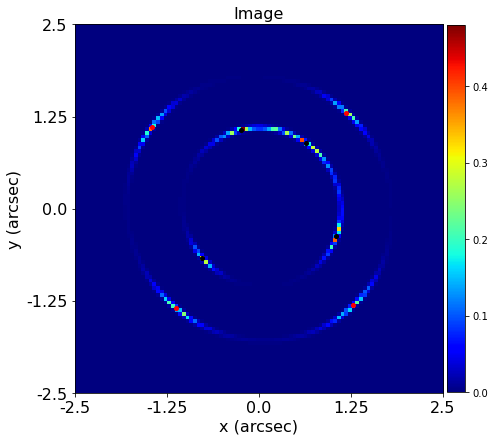

In [10]:
visuals_2d = aplt.Visuals2D(multiple_images=[positions_0, positions_1])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, visuals_2d=visuals_2d)
tracer_plotter.figures_2d(image=True)

mat_plot_2d = aplt.MatPlot2D(
    output=aplt.Output(path=dataset_path, filename="image_2d", format="fits")
)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.figures_2d(image=True)

mat_plot_2d = aplt.MatPlot2D(output=aplt.Output(path=dataset_path, format="png"))

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.subplot_tracer()

Create a point-source dictionary data object and output this to a `.json` file, which is the format used to load and
analyse the dataset.

In [11]:
point_source_dataset_0 = al.PointSourceDataset(
    name="point_0",
    positions=positions_0,
    positions_noise_map=positions_0.values_from_value(value=grid.pixel_scale),
    fluxes=fluxes_0,
    fluxes_noise_map=al.ValuesIrregular(values=[1.0, 1.0, 1.0, 1.0]),
)
point_source_dataset_1 = al.PointSourceDataset(
    name="point_1",
    positions=positions_1,
    positions_noise_map=positions_1.values_from_value(value=grid.pixel_scale),
    fluxes=fluxes_1,
    fluxes_noise_map=al.ValuesIrregular(values=[1.0, 1.0, 1.0, 1.0]),
)

point_source_dict = al.PointSourceDict(
    point_source_dataset_list=[point_source_dataset_0, point_source_dataset_1]
)

point_source_dict.output_to_json(
    file_path=path.join(dataset_path, "point_source_dict.json"), overwrite=True
)


Pickle the `Tracer` in the dataset folder, ensuring the true `Tracer` is safely stored and available if we need to 
check how the dataset was simulated in the future. 

This will also be accessible via the `Aggregator` if a model-fit is performed using the dataset.

In [12]:
tracer.save(file_path=dataset_path, filename="true_tracer")

Finished.